# Ischemic heart disease detection

# Import modules

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from matplotlib.colors import ListedColormap
import warnings; warnings.simplefilter('ignore')
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs

# Data preparation

In [22]:
# read data
df = pd.read_csv('./ischemia.txt', sep='\t') 

# shuffle 
df = df.sample(frac=1, random_state=0).reset_index(drop=True)        

# clean 
df = df.dropna()        

#factorize        
for c in ['Ischemia', 'Diastolic.function']:
    df[c], u = pd.factorize(df[c])    

In [23]:
# data visualization 
def show_histogram():
    name = ['age', 'E', 'A', 'e', 'a']
    for i in range(0, len(name)):        
        plt.subplot(5, 1, i+1)
        counts, bins = np.histogram(df[name[i]])
        plt.hist(bins[:-1], bins, weights=counts)
        plt.ylabel(name[i])            
    plt.show()                        

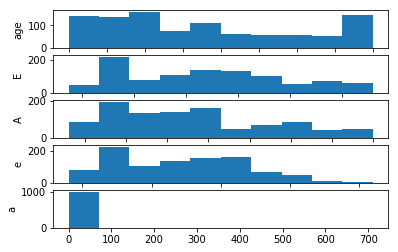

In [24]:
# before clear outlier
show_histogram()

### There is outlier data in 'a' feature

In [25]:
# clear outlier
df = df.loc[df['a'] < 0.2]

# normalize 
for c in ['age', 'E', 'A', 'e', 'a']:    
    df[c] = (df[c] - df[c].mean()) / df[c].std()    

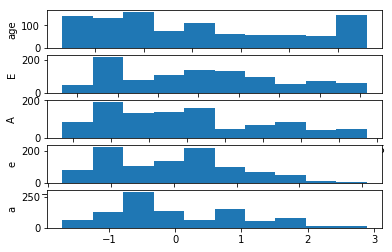

In [26]:
# after clear outlier
show_histogram()

### Split rows to feature and target

In [27]:
feature = df[df.columns[df.columns != 'Ischemia']]
target = df['Ischemia']

### Data split to test treain

In [28]:
# Split the data to train and test with a ratio of 3:1
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size=0.25)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(748, 6)
(748,)
(250, 6)
(250,)


In [29]:
# check data for balance target
def show_balance(tag):
    counts = np.histogram(tag,bins=2)
    fig, ax = plt.subplots()
    vals = np.array([[counts[0][0]], [counts[0][1]]])
    cmap = plt.get_cmap("tab20c")
    ax.pie(vals.sum(axis=1), radius=1)
    ax.set(aspect="equal", title='Compare 2 target abundance')
    plt.show()

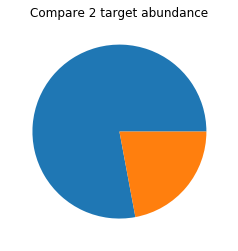

In [30]:
# before over sampling
show_balance(Y_train)

base on plot, we have a imbalanced dataset!

## Oversampling  for face imbalanced dataset and make it balance!

In [31]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
columns = X_train.columns 
sm = SMOTE(sampling_strategy='minority', random_state=2)
X_train, Y_train= sm.fit_sample(X_train, Y_train)
X_train = pd.DataFrame(X_train)
X_train.columns = columns
print(X_train.shape)

(1166, 6)


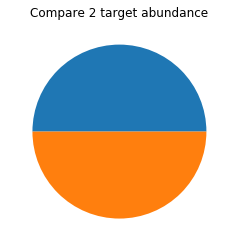

In [32]:
# after over sampling
show_balance(Y_train)

# function for show result 

In [108]:
def show_result(clf):        
    train_accuracy = accuracy_score(Y_train,clf.predict(X_train))        
    test_accuracy = accuracy_score(Y_test,clf.predict(X_test))
    print("train accuracy : " + str(train_accuracy))
    print("test accuracy : " + str(test_accuracy)+"\n")
    
    train_cm = confusion_matrix(Y_train,clf.predict(X_train))        
    test_cm = confusion_matrix(Y_test,clf.predict(X_test))        
    print("train confusion_matrix : \n" + str(train_cm))
    print("test confusion_matrix : \n" + str(test_cm)+"\n")
    
    train_bas = balanced_accuracy_score(Y_train,clf.predict(X_train))        
    test_bas = balanced_accuracy_score(Y_test,clf.predict(X_test))        
    print("train balanced_accuracy_score : \n" + str(train_bas))
    print("test balanced_accuracy_score : \n" + str(test_bas)+ "\n")
    
    train_fscore = f1_score(Y_train, clf.predict(X_train), average='binary')  
    test_fscore = f1_score(Y_test, clf.predict(X_test), average='binary')  
    print("train F-score : \n" + str(train_fscore))
    print("test F-score : \n" + str(test_fscore))

In [97]:
def cross_validation(clf, number=5):
    scores = cross_val_score(clf, X_train, Y_train, cv=number)
    print(scores)
    print(sum(scores)/number)

# SVM

In [110]:
clf_SVM = svm.SVC(gamma='scale')
clf_SVM.fit(X_train, Y_train)  
show_result(clf_SVM)

train accuracy : 0.9168096054888508
test accuracy : 0.92

train confusion_matrix : 
[[551  32]
 [ 65 518]]
test confusion_matrix : 
[[180  11]
 [  9  50]]

train balanced_accuracy_score : 
0.9168096054888508
test balanced_accuracy_score : 
0.8949330020409973

train F-score : 
0.9143865842894969
test F-score : 
0.8333333333333333


# KNN

### cross validation phase

In [111]:
for k in range(1,11,2):
    neigh = KNeighborsClassifier(n_neighbors=k)        
    print('for k = ' + str(k) + " :")
    cross_validation(neigh)

for k = 1 :
[0.93162393 0.95726496 0.94017094 0.94396552 0.93103448]
0.9408119658119658
for k = 3 :
[0.91452991 0.92307692 0.93162393 0.93103448 0.90948276]
0.9219496021220159
for k = 5 :
[0.8974359  0.90598291 0.93162393 0.92241379 0.90517241]
0.9125257883878574
for k = 7 :
[0.91025641 0.91025641 0.91880342 0.90517241 0.92241379]
0.9133804892425582
for k = 9 :
[0.91025641 0.9017094  0.91452991 0.89655172 0.91810345]
0.9082301797819039


### after cross validation chose hyperparameter value

In [112]:
# k = 1 is best for KNN
clf_KNN = KNeighborsClassifier(n_neighbors=1)
clf_KNN.fit(X_train, Y_train)
show_result(clf_KNN)

train accuracy : 0.9991423670668954
test accuracy : 0.892

train confusion_matrix : 
[[582   1]
 [  0 583]]
test confusion_matrix : 
[[177  14]
 [ 13  46]]

train balanced_accuracy_score : 
0.9991423670668953
test balanced_accuracy_score : 
0.8531812938148904

train F-score : 
0.9991431019708655
test F-score : 
0.773109243697479


# MLP

### cross validation phase

In [164]:
alpha = 0.01
clf = MLPClassifier(max_iter=1500, activation='logistic', solver='sgd', alpha=alpha,
                     momentum=0.95,batch_size='auto', random_state=1, validation_fraction=0.15)
cross_validation(clf)

[0.91025641 0.92307692 0.90598291 0.89655172 0.90086207]
0.9073460064839376


### after cross validation chose hyperparameter value

In [181]:
clf_MLP = MLPClassifier(max_iter=1500, activation='logistic', solver='sgd', alpha=0.01,
                     momentum=0.95,batch_size='auto', random_state=1, validation_fraction=0.15)

clf_MLP.fit(X_train, Y_train)
show_result(clf_MLP)

train accuracy : 0.9056603773584906
test accuracy : 0.924

train confusion_matrix : 
[[543  40]
 [ 70 513]]
test confusion_matrix : 
[[180  11]
 [  8  51]]

train balanced_accuracy_score : 
0.9056603773584906
test balanced_accuracy_score : 
0.9034075783121839

train F-score : 
0.9031690140845071
test F-score : 
0.8429752066115702


# Visualization

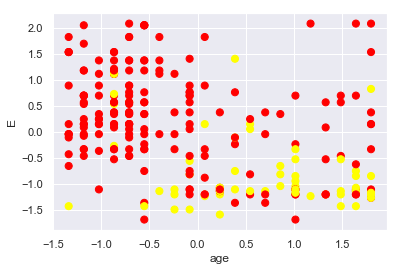

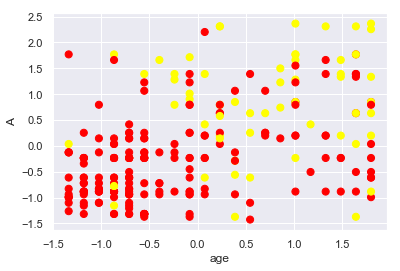

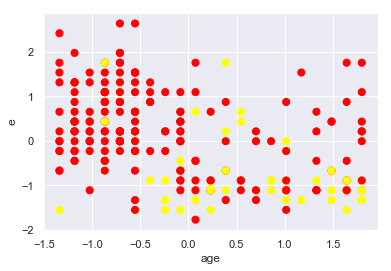

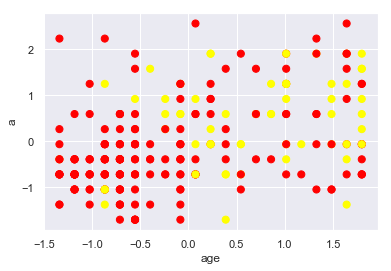

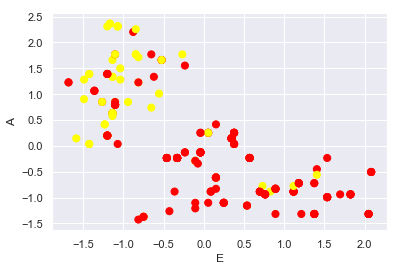

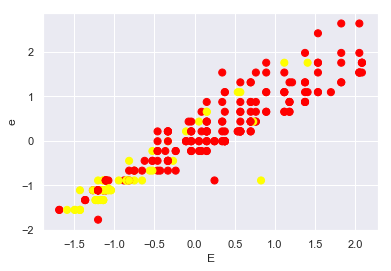

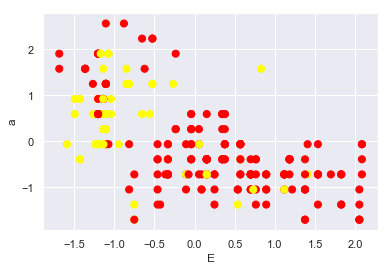

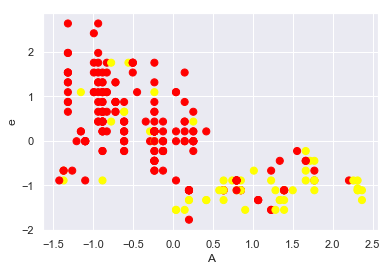

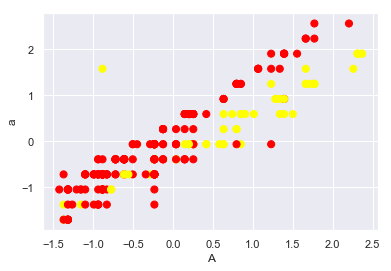

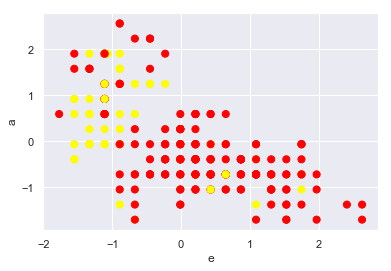

In [177]:
# for test data
k = 1
name = ['age', 'E', 'A', 'e', 'a']
for i in range(0,len(name)-1):    
    for j in range(i + 1, len(name)):
        #plt.subplot(10 ,1 , k)
        k += 1
        plt.scatter(X_test[name[i]], X_test[name[j]], c=Y_test, s=50, cmap='autumn');                
        plt.xlabel(name[i])
        plt.ylabel(name[j])        
        plt.show()